### Harmonic oscillator physics-informed neural network (PINN)

Consider the free simple harmonic oscilator, with linear damping term $F_D(v) = -bv$, where the parameter b is damping factor.
$$F = -bv - kx = -b\frac{dx}{dt} - kx \tag{1}$$

We can rewritten (1) as:
$$m\frac{d^2x}{dt^2} = kx - b\frac{dx}{dt} $$
$$\frac{d^2x}{dt^2} + \frac{b}{m}\frac{dx}{dt} + \frac{k}{m}x = 0 \tag{2}$$

The exponential ansatz states that a special solution to the differential equation takes the form:
$$ x(t) = C e^{\lambda t} \tag{3}$$ 

By forming the first and second derivations of (5) we obtain:
$$\frac{dx}{dt}(t) = \lambda C e^{\lambda t}, \quad \frac{d^2x}{dt^2}(t) = \lambda^2 C e^{\lambda t} \tag{4 e 5}$$

By inserting the equations (3), (4) and (5) into the differential equation (2) we obtain:
$$\lambda^2 C e^{\lambda t} + \frac{b}{m} \lambda C e^{\lambda t} + \frac{k}{m} C e^{\lambda t} $$
Then
$$\lambda^2 + \frac{b}{m} \lambda  + \frac{k}{m} \tag{6} $$

It is a quadratic equation in normal form. Therefore the following two solutions exist for $\lambda$:

$$\lambda_{1,2} = - \frac{\mu}{2m} \pm \sqrt{\left(\frac{\mu}{2m}\right)^2 - \frac{k}{m}} \tag{7}$$

To simplified

$$\delta = \frac{\mu}{2m}, \quad \omega_0 = \sqrt{\frac{k}{m}}$$

Then the equation (7) now

$$\lambda_{1,2} = - \delta \pm \sqrt{\delta^2 - \omega_0^2} \tag{8}$$

#### under-damped

Solving the problem for the under-damped state, i.e. when $\delta < \omega_0$

$$x(t) = e^{-\delta t}(2A\cos(\phi+\omega t)), \quad with \quad \omega = \sqrt{\omega_0^2 - \delta^2} \tag{9}$$

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def oscillator(d, w0, x):
    """Analytical solution to the 1D underdamped harmonic oscillator. 

    Args:
        d (int): delta
        w0 (float): frequency
        x (torch.tensor): input
    """
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w*x)
    sin = torch.sin(phi + w*x)
    exp = torch.exp(-d*x)
    y = exp * 2 * A * cos
    return y


class fcn(nn.Module):
    """Defines a connected network
    """
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        """Initializes the network
        Args:
            n_input (int): number of inputs
            n_output (int): number of outputs
            n_hidden (int): number of hidden neurons
            n_layers (int): number of layers
        """
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(n_input, n_hidden), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(n_hidden, n_hidden), activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_output)

    def forward (self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


def save_gif_PIL(outfile, files, fps=5, loop=0):
    """Function for saving GIFs

    Args:
        outfile (gif): output file
        files (png): images to be saved
        fps (int, optional): frame rate. Defaults to 5.
        loop (int, optional): Defaults to 0.
    """
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


def plot_result(x, y, x_data, y_data, yh, xp=None):
    """Pretty plot training results

    Args:
        x (torch.tensor): input
        y (torch.tensor): output
        x_data (torch.tensor): slice of input
        y_data (torch.tensor): slice of output
        yh (torch.tensor): neural network prediction
        xp (torch.tensor, optional): optional tensor for physics loss training locations. Defaults to None.
    """
    plt.figure(figsize = (8,4))
    plt.plot(x, y, label='Analytical solution', linestyle='--', color='tab:grey', alpha=0.8)
    plt.plot(x, yh, label='Neural network prediction', linewidth=4, color='tab:blue', alpha=0.8)
    plt.scatter(x_data, y_data, label='Training data', s=60, alpha=0.4, color='tab:red')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations', s=60, alpha=0.4, color="tab:green" )
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.5, 1.5)
    plt.text(1.065, 0.7, 'Training step: %i'%(i+1), fontsize='xx-large',color='k')
    plt.axis('off')

Computed from a given set of initial conditions, such as: $\delta = 2,\quad \omega_0 = 20$ over the domain $x \epsilon [0,1]$

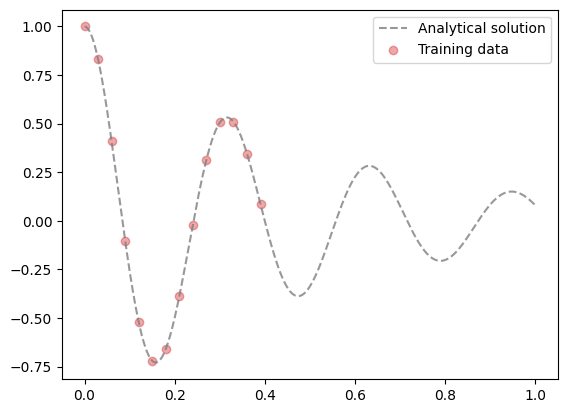

In [3]:
# The analytical solution over the full domain
d, w0 = 2, 20
x = torch.linspace(0,1,1000).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

# slice a small number of points from the LHS of the domain
x_data = x[0:400:30]
y_data = y[0:400:30]

plt.figure()
plt.plot(x, y, label='Analytical solution', linestyle='--', color='tab:gray', alpha=0.8)
plt.scatter(x_data, y_data, label='Training data', color='tab:red', alpha=0.4)
plt.legend()
plt.show()

#### Neural network

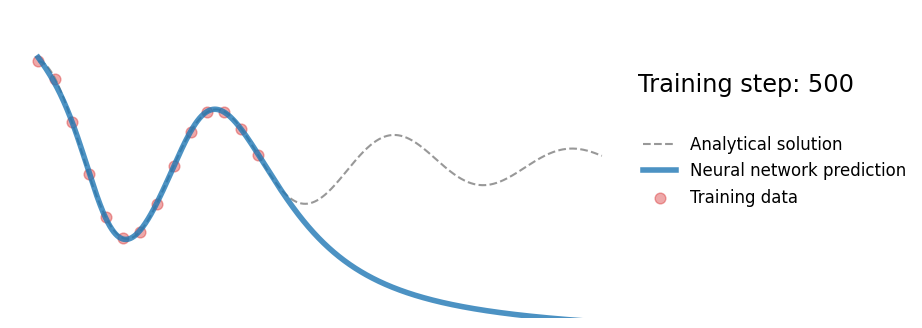

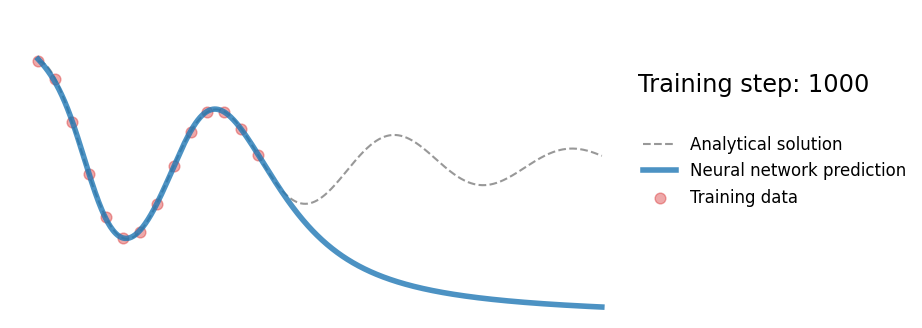

In [4]:
# Train standard neural network to fit training data
torch.manual_seed(123)
model = fcn(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = nn.MSELoss()(yh, y_data)

    loss.backward()
    optimizer.step()
    
    if (i+1) % 10 == 0:
        yh = model(x).detach()
        plot_result(x, y, x_data, y_data, yh)
        file = 'plots/nn_%.4i.png'%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 500 == 0:
            plt.show()
        else:
            plt.close('all')

save_gif_PIL('nn.gif', files, fps=20, loop=0)


#### PINN

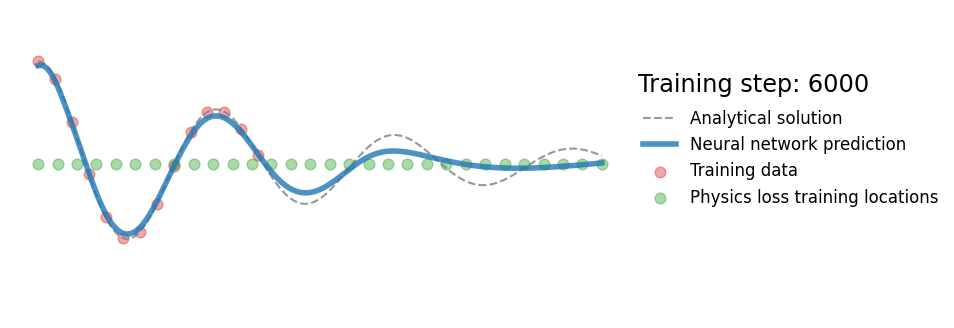

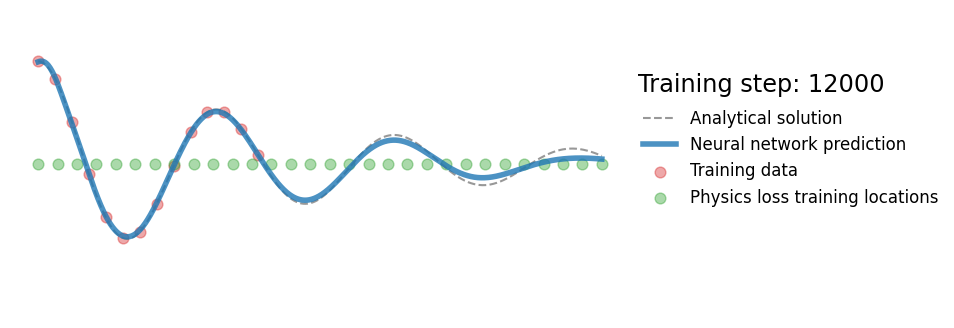

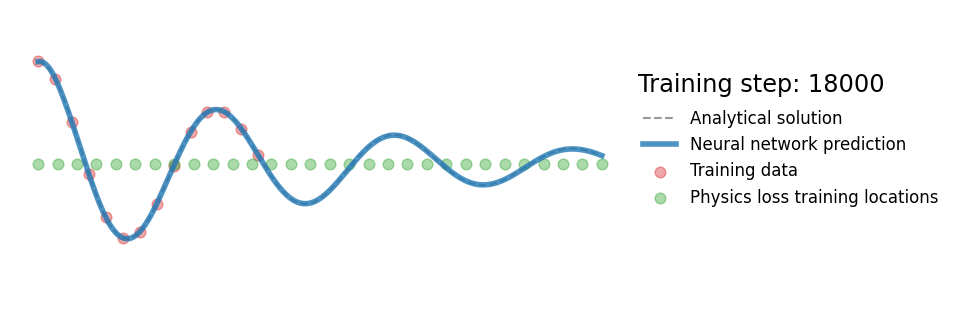

In [5]:
x_phy = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
m = 1
mu, k = 2*m*d, m*(w0**2)

torch.manual_seed(123)
model = fcn(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

files = []
for i in range(20000):
    optimizer.zero_grad()
    # loss nn
    yh = model(x_data)
    loss1 = nn.MSELoss()(yh, y_data)
    # loss physics
    yhp = model(x_phy)
    # dy/dx
    dx = torch.autograd.grad(yhp, x_phy, torch.ones_like(yhp), create_graph=True)[0]
    # d2y/dx2
    d2x = torch.autograd.grad(dx, x_phy, torch.ones_like(dx), create_graph=True)[0]
    # Differential equation harmonic oscillator
    physics = d2x + mu*dx + k*yhp
    # loss physics
    loss2 = (1e-4)*torch.mean(physics**2)

    # Backpropagation
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    if (i+1) % 150 == 0:
        yh = model(x).detach()
        xp = x_phy.detach()
        plot_result(x, y, x_data, y_data, yh, xp)

        file = 'plots/pinn_%.4i.png'%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0:
            plt.show()
        else:
            plt.close('all')
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)